# Pendeteksi Emosi Wajah

## Kelompok 5

1. Putu Yuki Parmawati (2208561066)
2. Ni Luh Gede Cahaya Putri Mahadewi (2208561110)
3. Made Pranajaya Dibyacita (2208561122)
4. Amsal Hamonangan Butarbutar (2208561134)

## Import Kaggle Dataset menggunakan API Kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d noamsegal/affectnet-training-data

Dataset URL: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data
License(s): Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO)
 99% 312M/314M [00:15<00:00, 27.6MB/s]
100% 314M/314M [00:15<00:00, 21.2MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/affectnet-training-data.zip', 'r')
zip_ref.extractall('/content/AffectNet')
zip_ref.close()

# 1. Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import sys
import random
from matplotlib import pyplot as plt
from skimage import data, io, feature, util, transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, layers
from pickle import dump
from PIL import Image

warnings.filterwarnings("ignore")
print("Python Version: {}".format(sys.version))

Python Version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


# 2. Siapkan Dataset AffectNet + Preprocessing

In [ ]:
happy = len(os.listdir(f'/content/AffectNet/happy/'))
sad = len(os.listdir(f'/content/AffectNet/sad/'))
anger = len(os.listdir(f'/content/AffectNet/anger/'))
disgust = len(os.listdir(f'/content/AffectNet/disgust/'))
fear = len(os.listdir(f'/content/AffectNet/fear/'))
neutral = len(os.listdir(f'/content/AffectNet/neutral/'))
surprise = len(os.listdir(f'/content/AffectNet/surprise/'))
contempt = len(os.listdir(f'/content/AffectNet/contempt/'))

# Membuat label untuk setiap gambar
labels = ['happy']*happy + ['sad']*sad + ['anger']*anger + ['disgust']*disgust + ['fear']*fear + ['neutral']*neutral + ['surprise']*surprise + ['contempt']*contempt

# Beri nama unutk setiap emosi
names = ['happy', 'sad', 'anger', 'disgust', 'fear', 'neutral', 'surprise', 'contempt']

### Menghitung total gambar pada setiap label

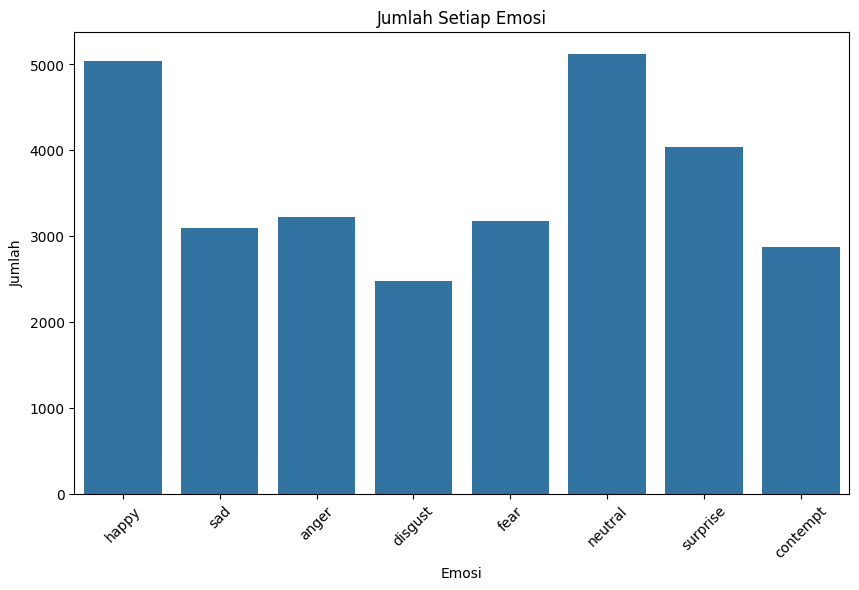

In [ ]:
df = pd.DataFrame()
df['label'] = labels

# Membuat plot jumlah
plt.figure(figsize=(10,6))
sns.countplot(x='label', data=df)
plt.title('Jumlah Setiap Emosi')
plt.xlabel('Emosi')
plt.ylabel('Jumlah')
plt.xticks(ticks=range(len(names)), labels=names, rotation=45)
plt.show()

### Menghitung total gambar pada dataset

In [ ]:
total_images = happy + sad + anger + disgust + fear + neutral + surprise + contempt

print("Total gambar:", total_images, "gambar")

Total gambar: 29042 gambar


### Preprocessing

In [ ]:
happy = os.listdir(f'/content/AffectNet/happy/')
sad = os.listdir(f'/content/AffectNet/sad/')
anger = os.listdir(f'/content/AffectNet/anger/')
disgust = os.listdir(f'/content/AffectNet/disgust/')
fear = os.listdir(f'/content/AffectNet/fear/')
neutral = os.listdir(f'/content/AffectNet/neutral/')
surprise = os.listdir(f'/content/AffectNet/surprise/')
contempt = os.listdir(f'/content/AffectNet/contempt/')

happy = ['/content/AffectNet/happy/' + i for i in happy]
sad = ['/content/AffectNet/sad/' + i for i in sad]
anger = ['/content/AffectNet/anger/' + i for i in anger]
disgust = ['/content/AffectNet/disgust/' + i for i in disgust]
fear = ['/content/AffectNet/fear/' + i for i in fear]
neutral = ['/content/AffectNet/neutral/' + i for i in neutral]
surprise = ['/content/AffectNet/surprise/' + i for i in surprise]
contempt = ['/content/AffectNet/contempt/' + i for i in contempt]

# Baca setiap file gambar/ubah sebagai gambar grayscale dan simpan dalam array numpy
happy = np.array([io.imread(i, as_gray=True) for i in happy])
sad = np.array([io.imread(i, as_gray=True) for i in sad])
anger = np.array([io.imread(i, as_gray=True) for i in anger])
disgust = np.array([io.imread(i, as_gray=True) for i in disgust])
fear = np.array([io.imread(i, as_gray=True) for i in fear])
neutral = np.array([io.imread(i, as_gray=True) for i in neutral])
surprise = np.array([io.imread(i, as_gray=True) for i in surprise])
contempt = np.array([io.imread(i, as_gray=True) for i in contempt])

### Mencari shape gambar (tinggi x lebar)

In [ ]:
# Mencari shape gambar pertama di setiap kategori
happy_shape = happy[0].shape
sad_shape = sad[0].shape
anger_shape = anger[0].shape
disgust_shape = disgust[0].shape
fear_shape = fear[0].shape
neutral_shape = neutral[0].shape
surprise_shape = surprise[0].shape
contempt_shape = contempt[0].shape

# Print shape
print(f"Shape pada label Happy: {happy_shape}")
print(f"Shape pada label Sad: {sad_shape}")
print(f"Shape pada label Anger: {anger_shape}")
print(f"Shape pada label Disgust: {disgust_shape}")
print(f"Shape pada label Fear: {fear_shape}")
print(f"Shape pada label Neutral: {neutral_shape}")
print(f"Shape pada label Surprise: {surprise_shape}")
print(f"Shape pada label Contempt: {contempt_shape}")

Shape pada label Happy: (96, 96)
Shape pada label Sad: (96, 96)
Shape pada label Anger: (96, 96)
Shape pada label Disgust: (96, 96)
Shape pada label Fear: (96, 96)
Shape pada label Neutral: (96, 96)
Shape pada label Surprise: (96, 96)
Shape pada label Contempt: (96, 96)


### Memvisualiasi salah satu gambar dengan label sebernarnya
Tinggi x lebar gambar = 96 x 96

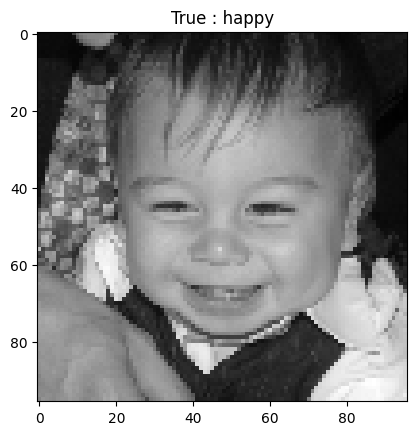

In [ ]:
# Buat daftar semua gambar dan labelnya
images = np.concatenate([happy, sad, anger, disgust, fear, neutral, surprise, contempt])
labels = ['happy']*len(happy) + ['sad']*len(sad) + ['anger']*len(anger) + ['disgust']*len(disgust) + ['fear']*len(fear) + ['neutral']*len(neutral) + ['surprise']*len(surprise) + ['contempt']*len(contempt)

# Pilih indeks acak
random_index = random.choice(range(len(images)))

# Cari gambar di indeks acak
img = images[random_index]

# Cari label untuk gambar tersebut
label = labels[random_index]

# Tampilkan gambar dan labelnya
plt.imshow(img, cmap='gray')
plt.title(f'True : {label}')
plt.show()

### Memvisualiasi salah satu gambar untuk setiap satu label

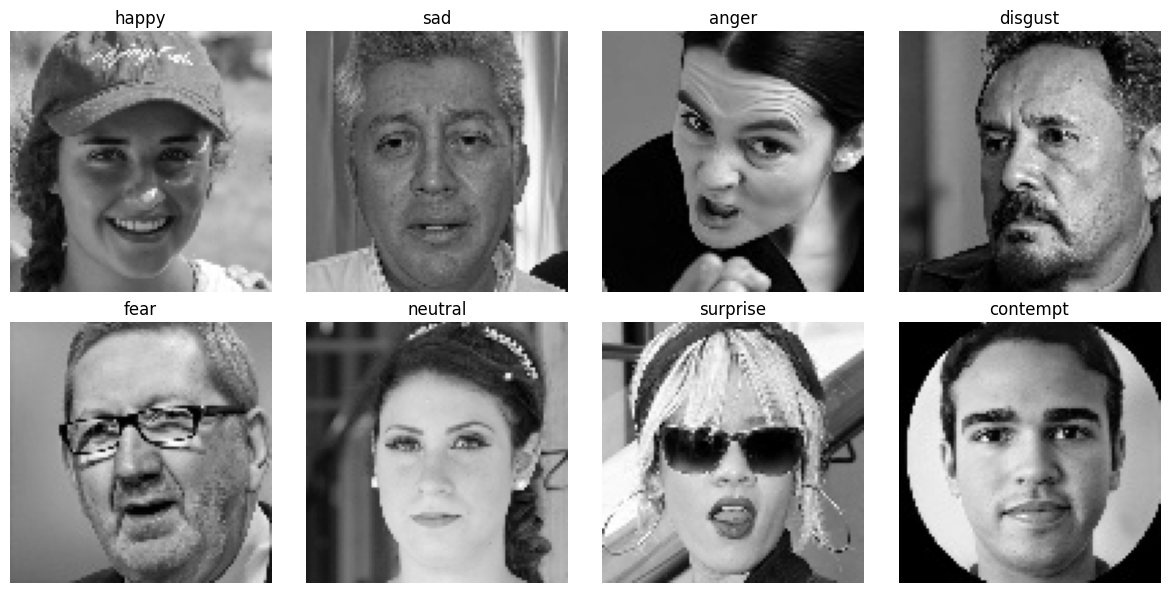

In [ ]:
emotions = ['happy', 'sad', 'anger', 'disgust', 'fear', 'neutral', 'surprise', 'contempt']
images = [happy, sad, anger, disgust, fear, neutral, surprise, contempt]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for ax, emotion, image in zip(axes.flatten(), emotions, images):
    ax.imshow(image[1], cmap='gray')
    ax.set_title(emotion)
    ax.axis('off')

plt.tight_layout()
plt.show()

# 2. Ekstraksi Fitur dengan GLCM dan proses ke DataFrame

In [ ]:
# Tentukan fitur tekstur dan sudut yang akan digunakan dalam perhitungan GLCM
features = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
angle = [0, 45, 90, 135, 180]

# Inisialisasi dictionary kosong untuk menyimpan hasilnya
df = {}

# Buat array numpy kosong untuk setiap kombinasi angle, features
for i in features:
    for j in angle:

        df[i.capitalize() + str(j)] = np.array([])

# Buat array numpy kosong untuk label
df['Label'] = np.array([])

# Proses setiap kategori emosi secara terpisah
# Untuk setiap gambar dalam kategori, ubah menjadi 8-bit, hitung GLCM, dan ekstrak fiturnya
# Tambahkan fitur dan label ke array yang sesuai di dictionary
# Catatan: Distance parameter pada fungsi GLCM berbeda-beda untuk setiap kategori

# Proses gambar 'happy'
for i in happy:
    i = util.img_as_ubyte(i) # Ubah gambar menjadi 8-bit
    for j in range(len(features)):

        # Hitung GLCM dan ekstrak fiturnya
        a = feature.graycomatrix(i, distances=[1], angles=angle, levels=256,
                            symmetric=True, normed=True)
        a = feature.graycoprops(a, prop=features[j]).flatten()

        # Tambahkan fitur ke array terkait di dictionary
        for k in range(len(angle)):
            df[features[j].capitalize() + str(angle[k])] = np.append(a[k], df[features[j].capitalize() + str(angle[k])])
    # Tambahkan label ke array 'Label'
    df['Label'] = np.append('Happy', df['Label'])

# Proses gambar 'sad'
for i in sad:
    i = util.img_as_ubyte(i)
    for j in range(len(features)):

        a = feature.graycomatrix(i, distances=[2], angles=angle, levels=256,
                            symmetric=True, normed=True)
        a = feature.graycoprops(a, prop=features[j]).flatten()

        for k in range(len(angle)):

            df[features[j].capitalize() + str(angle[k])] = np.append(a[k], df[features[j].capitalize() + str(angle[k])])
    df['Label'] = np.append('Sad', df['Label'])

# Proses gambar 'anger'
for i in anger:
    i = util.img_as_ubyte(i)
    for j in range(len(features)):

        a = feature.graycomatrix(i, distances=[3], angles=angle, levels=256,
                            symmetric=True, normed=True)
        a = feature.graycoprops(a, prop=features[j]).flatten()

        for k in range(len(angle)):

            df[features[j].capitalize() + str(angle[k])] = np.append(a[k], df[features[j].capitalize() + str(angle[k])])
    df['Label'] = np.append('Anger', df['Label'])

# Proses gambar 'disgust'
for i in disgust:
    i = util.img_as_ubyte(i)
    for j in range(len(features)):

        a = feature.graycomatrix(i, distances=[4], angles=angle, levels=256,
                            symmetric=True, normed=True)
        a = feature.graycoprops(a, prop=features[j]).flatten()

        for k in range(len(angle)):

            df[features[j].capitalize() + str(angle[k])] = np.append(a[k], df[features[j].capitalize() + str(angle[k])])
    df['Label'] = np.append('Disgust', df['Label'])

# Proses gambar 'fear'
for i in fear:
    i = util.img_as_ubyte(i)
    for j in range(len(features)):

        a = feature.graycomatrix(i, distances=[5], angles=angle, levels=256,
                            symmetric=True, normed=True)
        a = feature.graycoprops(a, prop=features[j]).flatten()

        for k in range(len(angle)):

            df[features[j].capitalize() + str(angle[k])] = np.append(a[k], df[features[j].capitalize() + str(angle[k])])
    df['Label'] = np.append('Fear', df['Label'])

# Proses gambar 'neutral'
for i in neutral:
    i = util.img_as_ubyte(i)
    for j in range(len(features)):

        a = feature.graycomatrix(i, distances=[6], angles=angle, levels=256,
                            symmetric=True, normed=True)
        a = feature.graycoprops(a, prop=features[j]).flatten()

        for k in range(len(angle)):

            df[features[j].capitalize() + str(angle[k])] = np.append(a[k], df[features[j].capitalize() + str(angle[k])])
    df['Label'] = np.append('Neutral', df['Label'])

# Proses gambar 'surprise'
for i in surprise:
    i = util.img_as_ubyte(i)
    for j in range(len(features)):

        a = feature.graycomatrix(i, distances=[7], angles=angle, levels=256,
                            symmetric=True, normed=True)
        a = feature.graycoprops(a, prop=features[j]).flatten()

        for k in range(len(angle)):

            df[features[j].capitalize() + str(angle[k])] = np.append(a[k], df[features[j].capitalize() + str(angle[k])])
    df['Label'] = np.append('Surprise', df['Label'])

# Proses gambar 'contempt'
for i in contempt:
    i = util.img_as_ubyte(i)
    for j in range(len(features)):

        a = feature.graycomatrix(i, distances=[8], angles=angle, levels=256,
                            symmetric=True, normed=True)
        a = feature.graycoprops(a, prop=features[j]).flatten()

        for k in range(len(angle)):

            df[features[j].capitalize() + str(angle[k])] = np.append(a[k], df[features[j].capitalize() + str(angle[k])])
    df['Label'] = np.append('Contempt', df['Label'])

# Ubah kamus menjadi DataFrame pandas
df = pd.DataFrame(df)

# 3. Melakukan analisis tekstur pada gambar Grayscale
Metode ini menggunakan GLCM untuk mengekstrak ukuran statistik tekstur dari gambar.

In [ ]:
def preprocessing_1(photo_dir):

    # Tentukan fitur dan angle yang akan digunakan dalam co-occurrence matrix (matriks kejadian) bersama tingkat grayscale (GLCM)
    features = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    angle = [0, 45, 90, 135, 180]

    # Inisialisasi array numpy kosong untuk menyimpan fitur GLCM
    res = np.array([])

    # Untuk setiap fitur, hitung GLCM dan ekstrak fiturnya
    for j in features:

        # Hitung GLCM
        a = feature.graycomatrix(photo_dir, distances=[2], angles=angle, levels=256,
                            symmetric=True, normed=True)
        # Esktrak fitur
        a = feature.graycoprops(a, prop=features[j]).flatten()

        # Tambahkan fitur ke array 'res'
        for k in range(len(angle)):

            res = np.append(a[k], res)

    # Kembalikan larik 'res' yang berisi fitur GLCM
    return res

# 4. Split/pisah data latih dan data uji pada dataset
Data uji dipisah sebanyak 25% dari total jumlah dataset

In [ ]:
# Pisahkan DataFrame menjadi fitur (X) dan label (y)
X, y = df.drop(columns=['Label']), df['Label']
# Inisialisasi StandardScaler
sc =  StandardScaler()
# Standarisasi fitur dengan menghilangkan mean dan menskalakan ke unit varians
X = sc.fit_transform(X)
# Inisialisasi LabelEncoder
le = LabelEncoder()
# Enkode label dengan nilai antara 0 dan n_classes-1
y = le.fit_transform(y)
# Pisahkan data menjadi data latih dan data uji
# Data uji akan berjumlah 25% dari total data, dan data diacak sebelum dipecah
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=0)

In [ ]:
df[0:]

,Dissimilarity0,Dissimilarity45,Dissimilarity90,Dissimilarity135,Dissimilarity180,Correlation0,Correlation45,Correlation90,Correlation135,Correlation180,...,Asm45,Asm90,Asm135,Asm180,Energy0,Energy45,Energy90,Energy135,Energy180,Label
0,50.635535,38.708232,38.877259,51.088636,42.128205,0.421231,0.635878,0.668042,0.414326,0.582473,...,0.000120,0.000112,0.000101,0.000112,0.009996,0.010969,0.010592,0.010072,0.010593,Contempt
1,38.597656,37.854910,37.013190,38.287919,38.321734,0.478704,0.561166,0.534423,0.489365,0.543218,...,0.000113,0.000117,0.000116,0.000113,0.010691,0.010650,0.010831,0.010751,0.010627,Contempt
2,48.465554,47.161822,46.656571,47.639474,48.060073,0.436785,0.428754,0.437831,0.449200,0.420952,...,0.001129,0.001334,0.000692,0.001000,0.025810,0.033600,0.036526,0.026311,0.031627,Contempt
3,37.282670,40.591475,41.982535,37.650000,39.294505,0.576477,0.505904,0.469095,0.573907,0.533129,...,0.000158,0.000159,0.000153,0.000155,0.012478,0.012566,0.012616,0.012358,0.012467,Contempt
4,34.230232,24.703591,27.764533,34.639952,26.990842,0.683831,0.803063,0.776646,0.682604,0.770575,...,0.000372,0.000324,0.000249,0.000343,0.015848,0.019275,0.017993,0.015789,0.018507,Contempt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29037,10.908333,13.262715,10.260855,10.908333,13.262715,0.953972,0.938679,0.959099,0.953972,0.938679,...,0.001244,0.001414,0.001320,0.001244,0.036331,0.035266,0.037597,0.036331,0.035266,Happy
29038,12.093969,15.037341,11.610197,12.093969,15.037341,0.946136,0.915346,0.947201,0.946136,0.915346,...,0.000344,0.000429,0.000370,0.000344,0.019225,0.018537,0.020712,0.019225,0.018537,Happy
29039,7.034101,8.896399,8.479386,7.034101,8.896399,0.963985,0.946106,0.949835,0.963985,0.946106,...,0.012130,0.012211,0.012349,0.012130,0.111127,0.110134,0.110503,0.111127,0.110134,Happy
29040,11.205921,13.790582,11.221491,11.205921,13.790582,0.928671,0.902968,0.929796,0.928671,0.902968,...,0.000228,0.000272,0.000287,0.000228,0.016946,0.015099,0.016483,0.016946,0.015099,Happy


# 5. Membangun dan melatih model menggunakan JST

In [25]:
# Tentukan arsitektur model
model = Sequential([
    layers.Dense(30, activation='relu'), # Dense layer pertama dengan 30 neuron dan fungsi aktivasi ReLU
    layers.Dense(256, activation='relu'), # Dense layer kedua dengan 256 neuron dan fungsi aktivasi ReLU
    layers.Dense(512, activation='relu'), # Dense layer ketiga dengan 512 neuron dan fungsi aktivasi ReLU
    layers.Dense(1024, activation='relu'), # Dense layer keempat dengan 1024 neuron dan fungsi aktivasi ReLU
    layers.Dropout(0.25), # Lapisan dropout untuk mencegah overfitting, dengan 25% neuron
    layers.Dense(1024, activation='relu'), # Dense layer nkelima dengan 1024 neuron dan fungsi aktivasi ReLU
    layers.Dense(512, activation='relu'), # Dense layer keenam dengan 512 neuron dan fungsi aktivasi ReLU
    layers.Dense(256, activation='relu'), # Dense layer ketujuh dengan 256 neuron dan fungsi aktivasi ReLU
    layers.Dense(8, activation='softmax') # Output layer dengan 8 neuron (untuk 8 kelas/label) dan fungsi aktivasi softmax
])

# Kompilasi model dengan optimizer Adam
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Melatih model

In [26]:
batch_size = 128
model.fit(X_train, y_train, epochs=50, batch_size=batch_size)

Epoch 1/50
171/171 [==============================] - 14s 75ms/step - loss: 0.9871 - accuracy: 0.6062
Epoch 2/50
171/171 [==============================] - 15s 88ms/step - loss: 0.5557 - accuracy: 0.7860
Epoch 3/50
171/171 [==============================] - 19s 110ms/step - loss: 0.4496 - accuracy: 0.8266
Epoch 4/50
171/171 [==============================] - 17s 99ms/step - loss: 0.4069 - accuracy: 0.8398
Epoch 5/50
171/171 [==============================] - 16s 91ms/step - loss: 0.4023 - accuracy: 0.8424
Epoch 6/50
171/171 [==============================] - 17s 99ms/step - loss: 0.3739 - accuracy: 0.8521
Epoch 7/50
171/171 [==============================] - 16s 96ms/step - loss: 0.3587 - accuracy: 0.8587
Epoch 8/50
171/171 [==============================] - 13s 73ms/step - loss: 0.3573 - accuracy: 0.8612
Epoch 9/50
171/171 [==============================] - 13s 74ms/step - loss: 0.3473 - accuracy: 0.8621
Epoch 10/50
171/171 [==============================] - 13s 74ms/step - loss: 0.33

# 6. Eksperimen Tuning Hyperparameter & K-Fold Cross Validation

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from sklearn.model_selection import KFold
import numpy as np

# Definisikan arsitektur model
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_input', min_value=30, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dense(units=hp.Int('units_hidden', min_value=256, max_value=1024, step=32), activation='relu'))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.05)))
    model.add(layers.Dense(8, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Inisialisasi tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='emotion_recognition')

# Melakukan pencarian hyperparameter
tuner.search(X_train, y_train, epochs=50, validation_split=0.2)

# Mendapatkan hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Membangun model dengan hyperparameter terbaik
model = tuner.hypermodel.build(best_hps)

Trial 5 Complete [00h 17m 08s]
val_accuracy: 0.9120954672495524

Best val_accuracy So Far: 0.9172213276227316
Total elapsed time: 00h 51m 09s


### K-Fol Cross Validation, K = 10

In [23]:
# Melakukan k-fold cross validation
kfold = KFold(n_splits=10, shuffle=True)
for train, test in kfold.split(X_train, y_train):
    model.fit(X_train[train], y_train[train], epochs=50, batch_size=128)
    scores = model.evaluate(X_train[test], y_train[test])
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/50
154/154 [==============================] - 2s 7ms/step - loss: 1.0301 - accuracy: 0.6051
Epoch 2/50
154/154 [==============================] - 1s 7ms/step - loss: 0.5079 - accuracy: 0.8090
Epoch 3/50
154/154 [==============================] - 1s 10ms/step - loss: 0.4367 - accuracy: 0.8279
Epoch 4/50
154/154 [==============================] - 2s 11ms/step - loss: 0.4009 - accuracy: 0.8433
Epoch 5/50
154/154 [==============================] - 2s 10ms/step - loss: 0.3857 - accuracy: 0.8486
Epoch 6/50
154/154 [==============================] - 1s 7ms/step - loss: 0.3591 - accuracy: 0.8582
Epoch 7/50
154/154 [==============================] - 1s 7ms/step - loss: 0.3450 - accuracy: 0.8649
Epoch 8/50
154/154 [==============================] - 1s 7ms/step - loss: 0.3314 - accuracy: 0.8720
Epoch 9/50
154/154 [==============================] - 1s 7ms/step - loss: 0.3230 - accuracy: 0.8735
Epoch 10/50
154/154 [==============================] - 1s 7ms/step - loss: 0.3063 - accuracy: 0.8

# 7. Evaluasi Model

In [30]:
from sklearn.metrics import classification_report

# Dengan asumsi `y_pred` adalah keluaran prediksi model
y_pred_classes = np.argmax(y_pred, axis=1)

# Dengan asumsi `y_test` adalah label pengujian
y_true = y_test

# Hasilkan laporan klasifikasi
report = classification_report(y_true, y_pred_classes, target_names=['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'contempt'])

print(report)

              precision    recall  f1-score   support

       anger       1.00      0.99      0.99       809
     disgust       0.78      0.86      0.82       713
        fear       0.83      0.76      0.79       604
       happy       0.69      0.67      0.68       784
     neutral       0.99      0.99      0.99      1295
         sad       0.99      0.95      0.97      1276
    surprise       0.86      0.92      0.89       789
    contempt       0.74      0.73      0.73       991

    accuracy                           0.87      7261
   macro avg       0.86      0.86      0.86      7261
weighted avg       0.87      0.87      0.87      7261



In [31]:
# Dengan asumsi `X_test` dan `y_test` adalah data dan label pengujian
loss, accuracy = model.evaluate(X_test, y_test)

print(f'\nTotal akurasi keseluruhan: {accuracy:.3f} atau {accuracy*100:.0f}%')

227/227 [==============================] - 2s 6ms/step - loss: 0.4463 - accuracy: 0.8743

Total akurasi keseluruhan: 0.874 atau 87%


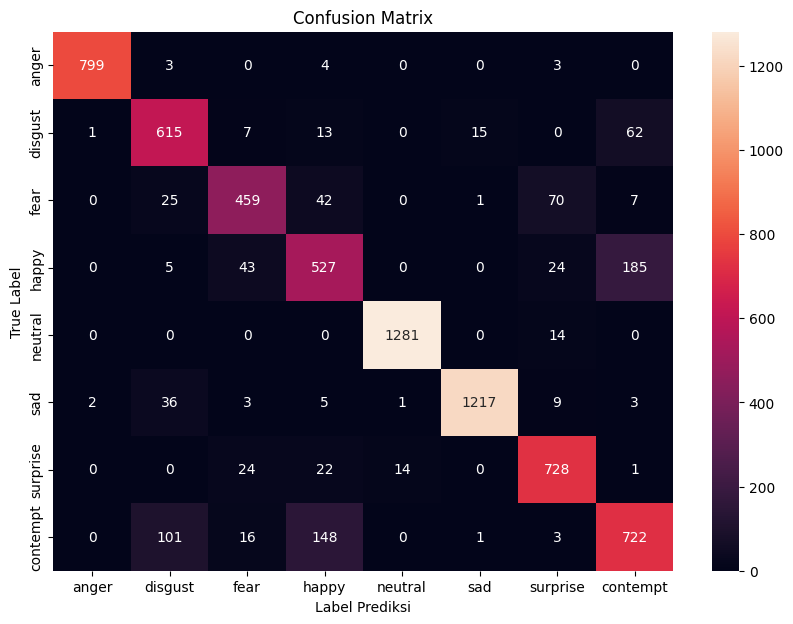

In [32]:
# Dengan asumsi `y_pred` adalah keluaran prediksi model
y_pred_classes = np.argmax(y_pred, axis=1)

# Dengan asumsi `y_test` adalah label pengujian
y_true = y_test

# Menghasilkan confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Tentukan nama kelas
names = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'contempt']

# Plot confusion matrix sebagai heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=names, yticklabels=names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Label Prediksi')
plt.show()

In [33]:
print(f'X_train[0] shape: {X_train[0].shape}')
print(f'y_train shape: {y_train.shape}')
print(f'Data type: {X_train[0].dtype}')
print(f'Number of elements: {X_train[0].size}')

X_train[0] shape: (30,)
y_train shape: (21781,)
Data type: float64
Number of elements: 30


In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                930       
                                                                 
 dense_7 (Dense)             (None, 256)               7936      
                                                                 
 dense_8 (Dense)             (None, 512)               131584    
                                                                 
 dense_9 (Dense)             (None, 1024)              525312    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_11 (Dense)            (None, 512)              

# 8. Save Model

In [ ]:
model.save('model/model.h5')
dump(sc, open('model/scaling.pkl', 'wb'))
dump(le, open('model/label.pkl', 'wb'))

# 9. Prediksi

1/1 [==============================] - 0s 146ms/step


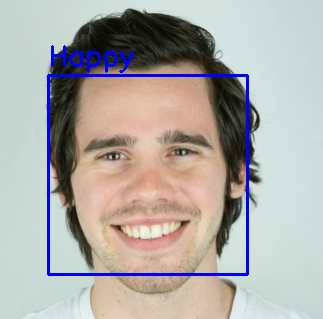

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from keras.models import load_model
from joblib import load
from skimage import feature, util
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Memuat model, scaler, dan encoder label
model = load_model('/content/model.h5')  # ganti dengan path model
scaler = load('/content/scaling.pkl')  # ganti dengan path scaler
label_encoder = load('/content/label.pkl')  # ganti dengan path encoder label

# Memuat file xml Haar cascade untuk deteksi wajah
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Mendefinisikan fungsi GLCM dan preprocessing
def preprocessing_1(image):
    features = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    angle = [0, 45, 90, 135, 180]
    res = np.array([])
    image = util.img_as_ubyte(image)
    for j in range(len(features)):
        a = feature.graycomatrix(image, distances=[2], angles=angle, levels=256,
                            symmetric=True, normed=True)
        a = feature.graycoprops(a, prop=features[j]).flatten()
        for k in range(len(angle)):
            res = np.append(a[k], res)
    return res

# Memuat gambar
image_path = '/content/HappyExpression.png'  # ganti dengan path gambar
img = cv2.imread(image_path)

# Mengkonversi gambar ke grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Mendeteksi wajah dalam gambar
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    # Menggambar persegi di sekitar wajah
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

    # Mendapatkan gambar wajah
    face_img = gray[y:y+h, x:x+w]

    # Mengubah ukuran gambar wajah ke ukuran yang diharapkan oleh model (diasumsikan 48x48 piksel)
    resized_face = cv2.resize(face_img, (48, 48))

    # Melakukan preprocessing pada gambar wajah
    preprocessed_face = preprocessing_1(resized_face)

    # Membuat prediksi
    prediction = model.predict(scaler.transform([preprocessed_face]))

    # Mendapatkan kelas yang diprediksi
    predicted_class = np.argmax(prediction)

    # Mendekode label yang diprediksi
    predicted_label = label_encoder.inverse_transform([predicted_class])

    # Menampilkan label yang diprediksi pada gambar
    cv2.putText(img, str(predicted_label[0]), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)

# Menampilkan gambar
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()